# Note

If you do not want to plot the results on some platforms like Enarx, you can just remove the unneeded ones. To plot the figures with LaTeX, you must install `texlive-full` first.

# Figure for Polybench

In [2]:
import re


def process_time(time):
    res = 0
    time = time.split('m')

    if len(time) != 1:
        res += float(time[0]) * 60000
    time = time[-1]

    if 'ms' in time:
        time = float(re.sub(r'ms.*\n', '', time))
        res += time
    elif 'ns' in time:
        time = float(re.sub(r'ns.*\n', '', time)) * 1e-6
        res += time
    elif 's' in time:
        time = float(re.sub(r's.*\n', '', time)) * 1000
        res += time

    return res


def extract_elapsed_ms(file, type):
    ans = []
    init_time = 0
    with open(file, "r", encoding="utf-8", errors="ignore") as file:
        for line in file:
            if ("time" in line or "Time" in line or "Elapsed" in line) and 'time...' not in line and '...' not in line:
                splitted = line.split(" ")
                time = splitted[-1]

                ans.append(process_time(time))
            elif ('initialization takes' in line or 'Initialization takes' in line) and type == 'mt':
                splitted = line.split(' ')
                time = splitted[-1]
                init_time = process_time(time)
                ans.append(init_time)
            # Calculate real time.
            elif 'real' in line and type == 'mt':
                splitted = line.split('\t')
                time = splitted[-1]
                time = process_time(time)
                ans.append(time)

    if ans == []:
        raise Exception("Could not find time in file")
    else:
        return ans


In [ ]:
# def extract(file, task_identifier):
#     for line in open(file, "r"):
#         if task_identifier in line:
#             return int(line.split(" ")[-2])

#     raise Exception("Could not find %s in file", task_identifier)


In [3]:
import os


def polypench_analyze(focused):
    result = {}
    path = "/home/data/task_polybench/"
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname == path:
            for dir in subdirlist:
                result[dir] = []
            continue

        # skip root directory is skipped
        for fname in filelist:
            subtask = os.path.basename(os.path.normpath(dirname))
            if focused in fname:
                data = extract_elapsed_ms(dirname + "/" + fname)
                result[subtask].extend(data)

    return result


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

poly_native = polypench_analyze("enclave_native")
poly_native = pd.DataFrame(poly_native)
poly_native = poly_native.transpose()

poly_pobf = polypench_analyze("enclave_pobf")
poly_pobf = pd.DataFrame(poly_pobf)
poly_pobf = poly_pobf.transpose()

poly = {}
poly["native"] = {}
poly["pobf"] = {}

for i in poly_native.index:
    poly["native"][i] = np.average(poly_native.loc[i])
    poly["pobf"][i] = np.average(poly_pobf.loc[i])

poly = pd.DataFrame(poly)
for i in poly.index:
    poly.loc[i, "overhead"] = (
        (poly.loc[i, "pobf"] / poly.loc[i, "native"]) - 1) * 100

np.average(poly["overhead"])


In [ ]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in poly.index:
    xs.append(i)
    xs.append(i)
    ys.append(poly["native"][i])
    ys.append(poly["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")

assert (len(xs) == len(ys))
g = sns.barplot(x=xs, y=ys, hue=hue)
# g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = "  " + poly["overhead"].round(1).astype(str)

g.bar_label(g.containers[0], labels=overhead_precentage, fontsize=7, padding=3)
g.set_ylabel("Time (ms)", fontsize=12)
plt.savefig("../polybench.pdf", bbox_inches='tight')


# Figure for Identity Function

In [ ]:
def identity_analyze(focused):
    result = []
    path = "../data/task_sample/"
    for dirname, subdirlist, filelist in os.walk(path):
        if dirname != path:
            break
        for f in filelist:
            if focused in f:
                result.extend(extract_elapsed_ms(path + f,))
    return result


In [ ]:
datasizes = {"1kb": 1000, "10kb": 10000, "100kb": 100000,
             "1mb": 1000000, "10mb": 10000000, "100mb": 100000000}

identifiers = ["native", "pobf"]
identity = {id: {} for id in identifiers}

for size_str in datasizes:
    for id in identifiers:
        file_partial_name = size_str + "output_enclave_" + id + ".txt"
        data = identity_analyze(file_partial_name)
        assert (len(data) == 10)
        identity[id][size_str] = np.average(data)

identity = pd.DataFrame(identity)
for i in identity.index:
    identity.loc[i, "overhead"] = (
        (identity.loc[i, "pobf"] / identity.loc[i, "native"]) - 1) * 100

identity.round(3).transpose()


In [ ]:
sns.set(style="whitegrid")
xs = []
ys = []
hue = []
overhead = []
for i in identity.index:
    xs.append(i)
    xs.append(i)
    ys.append(identity["native"][i])
    ys.append(identity["pobf"][i])
    hue.append("Native")
    hue.append("PoCF")

assert (len(xs) == len(ys))
g = sns.lineplot(x=xs, y=ys, hue=hue, markers=True)
g.set_yscale("log")
g.set_xticklabels(g.get_xticklabels(), rotation=90)

overhead_precentage = " " + identity["overhead"].round(1).astype(str)

# g.bar_label(g.containers[0], labels = overhead_precentage, fontsize=7, padding=3)
g.set_ylabel("Time (ms)", fontsize=12)
plt.savefig("../polybench.pdf", bbox_inches='tight')


# Figure for Macrobenchmarks

In [4]:
import os

# Analyze single-threaded macrobenchmarks.


def analyze_macrobenchmarks(focused, type, pos=-1):
    result = {}
    throughput = {}
    # Tasks.
    tasks = ["task_tvm", "task_fasta"]

    for task in tasks:
        path = "/home/haobchen/data/" + task + "/"
        result[task] = []
        for dirname, subdirlist, filelist in os.walk(path):
            for fname in filelist:
                if focused in fname:
                    if (type == 'st' and 'mt_' not in fname) or (type == 'mt' and 'mt_' in fname):
                        data = extract_elapsed_ms(dirname + "/" + fname, type)
                        if type == 'st':
                            result[task].extend(data)
                        elif type == 'mt':
                            result[task].append(data)

        # Calculate throughput for multithreaded programs.
        if type == 'mt':
            # 2 stands for init + real.
            # [init_time, xxx, xxx, real_time] or [xxx, xxx, real_time, init_time]
            requests = len(result[task][0]) - 2
            test_suites = len(result[task])
            real_time = 0

            print("task:", task, result[task])
            for test in result[task]:
                real_time += abs(test[pos] - test[-1])
                print(test[pos], test[-1])
            real_time /= test_suites
            throughput[task] = []
            throughput[task].append(real_time / requests)

        result[task] = np.average(result[task])

    return result, throughput


## Plot single-threaded - TVM

['Linux', 'SGX-Native', 'SGX-PoCF', 'Occlum', 'Gramine', 'Enarx', 'SEV-Native', 'SEV-PoCF'] [2.2785271039000006, 2.9492393456999997, 2.9417496463, 2.2369931084999997, 4.066203897999999, 19.1802640981, 1.922022375, 1.9199999]


/tmp/ipykernel_856041/2297599685.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=24)


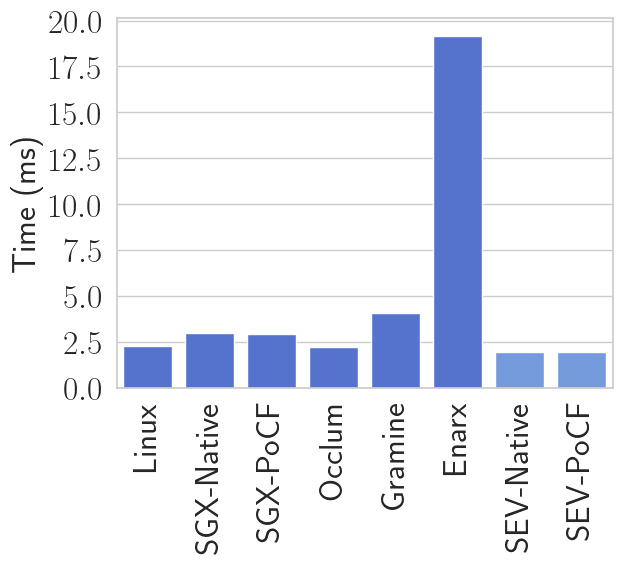

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
plt.rcParams['mathtext.default'] = 'sf'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24
plt.rc('legend',fontsize=24)
platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine', 'enarx']

ys = []
for platform in platforms:
    cur, _ = analyze_macrobenchmarks('data_provider_' + platform, 'st')
    for k, v in cur.items():
        ys.append(v / 1000)

ys = ys[::2]
ys.append(1.922022375)
ys.append(1.9199999)
print(xs, ys)
sns.set(style='whitegrid')
xs =  ['Linux', 'SGX-Native', 'SGX-PoCF',  'Occlum', 'Gramine', 'Enarx', 'SEV-Native', 'SEV-PoCF',]
# xs =  ['Linux', 'SGX-Native', 'SGX-PoCF', 'Occlum', 'Gramine', 'Enarx']
colors = ['royalblue', 'royalblue', 'royalblue','royalblue', 'royalblue', 'royalblue', 'cornflowerblue', 'cornflowerblue']
g = sns.barplot(x=xs, y=ys, palette=colors)
g.set_ylabel('Time (ms)', fontsize=24)
g.set_xticklabels(g.get_xticklabels(), size=24, rotation=90)
g.set_yticklabels(g.get_yticklabels(), size=24)
plt.savefig("./macrobenchmarks_st_tvm.pdf", bbox_inches='tight')


## Plot single-threaded - FASTA

[2.2020557823999996, 3.9857979474, 3.9430065797, 2.3734829703, 3.1109411432999994, 3.1722060715, 2.3811201, 2.3906109]


/tmp/ipykernel_856041/611758152.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=24)


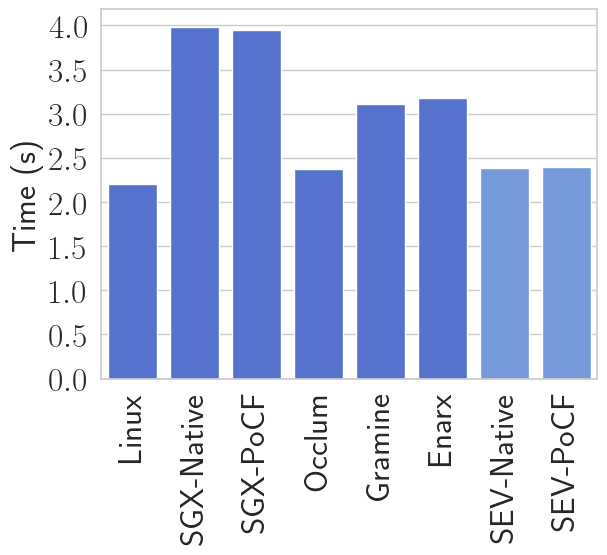

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine', 'enarx']

ys = []
for platform in platforms:
    cur, _ = analyze_macrobenchmarks('data_provider_' + platform, 'st')
    for k, v in cur.items():
        ys.append(v / 1000)

sns.set(style='whitegrid')
ys = ys[1::2]
ys.append(2.3811201)
ys.append(2.3906109)
xs =  ['Linux', 'SGX-Native', 'SGX-PoCF',  'Occlum', 'Gramine', 'Enarx', 'SEV-Native', 'SEV-PoCF',]
print(ys)
colors = ['royalblue', 'royalblue', 'royalblue','royalblue', 'royalblue', 'royalblue',  'cornflowerblue', 'cornflowerblue',]
g = sns.barplot(x=xs, y=ys, palette=colors)
g.set_ylabel('Time (s)', fontsize=24)
g.set_xticklabels(g.get_xticklabels(), size=24, rotation=90)
g.set_yticklabels(g.get_yticklabels(), size=24)
plt.savefig("./macrobenchmarks_st_fasta.pdf", bbox_inches='tight')


## Plot multi-threaded - TVM

task: task_tvm [[2158.050486, 2381.578519, 2458.965708, 2566.884267, 2863.0, 6.972674], [2090.136834, 2266.076572, 2554.343455, 2596.767414, 2891.0, 6.506285], [2389.484935, 2448.126647, 2480.505977, 2532.647666, 2849.0, 6.719287], [2106.820131, 2144.4699100000003, 2208.743552, 2427.663365, 2733.0, 7.047141], [2098.410903, 2132.727856, 2234.624804, 2685.551695, 2957.0, 6.925528], [2091.7226800000003, 2247.457492, 2288.74954, 2326.068757, 2623.0, 6.818026], [2097.551011, 2238.0650530000003, 2280.1738779999996, 2334.1238670000002, 2636.0, 6.393532], [2092.405585, 2231.255645, 2269.06813, 2484.770388, 2784.0, 6.212466], [2094.69665, 2123.301058, 2194.8489680000002, 2235.565474, 2505.0, 6.1286819999999995], [2113.9148579999996, 2149.37177, 2191.701479, 2235.198909, 2529.0, 6.855445]]
2863.0 6.972674
2891.0 6.506285
2849.0 6.719287
2733.0 7.047141
2957.0 6.925528
2623.0 6.818026
2636.0 6.393532
2784.0 6.212466
2505.0 6.1286819999999995
2529.0 6.855445
task: task_fasta [[2102.811646, 2251.94

/tmp/ipykernel_856041/2932059270.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=24)


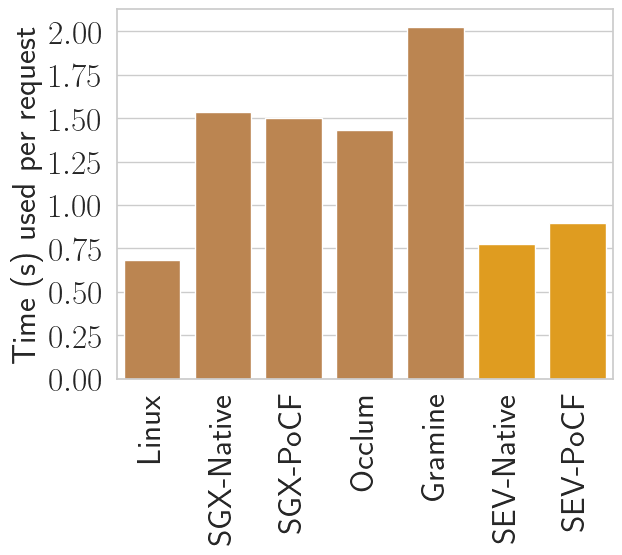

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine']

ys = []
for platform in platforms:
    pos = -2
    if platform == 'pobf' or platform == 'native':
          pos = 0
    _, trpt = analyze_macrobenchmarks('output_enclave_' + platform, 'mt', pos=pos)
    for k,v in trpt.items():
        ys.append(v[0] / 1000)

sns.set(style='whitegrid')
xs =  ['Linux', 'SGX-Native', 'SGX-PoCF',  'Occlum', 'Gramine', 'SEV-Native', 'SEV-PoCF',]
ys =ys[::2]
ys.append(0.7726)
ys.append(0.89755)
colors = ['peru', 'peru', 'peru', 'peru',  'peru', 'orange', 'orange',]
g = sns.barplot(x=xs, y=ys, palette=colors)
g.set_ylabel('Time (s) used per request', fontsize=24)
# g.set_xlabel('Platforms', fontsize=18)
g.set_xticklabels(g.get_xticklabels(), size=24, rotation=90)
g.set_yticklabels(g.get_yticklabels(), size=24)
plt.savefig("./macrobenchmarks_mt_tvm.pdf", bbox_inches='tight')


## Plot Multi-threaded - FASTA

task: task_tvm [[2158.050486, 2381.578519, 2458.965708, 2566.884267, 2863.0, 6.972674], [2090.136834, 2266.076572, 2554.343455, 2596.767414, 2891.0, 6.506285], [2389.484935, 2448.126647, 2480.505977, 2532.647666, 2849.0, 6.719287], [2106.820131, 2144.4699100000003, 2208.743552, 2427.663365, 2733.0, 7.047141], [2098.410903, 2132.727856, 2234.624804, 2685.551695, 2957.0, 6.925528], [2091.7226800000003, 2247.457492, 2288.74954, 2326.068757, 2623.0, 6.818026], [2097.551011, 2238.0650530000003, 2280.1738779999996, 2334.1238670000002, 2636.0, 6.393532], [2092.405585, 2231.255645, 2269.06813, 2484.770388, 2784.0, 6.212466], [2094.69665, 2123.301058, 2194.8489680000002, 2235.565474, 2505.0, 6.1286819999999995], [2113.9148579999996, 2149.37177, 2191.701479, 2235.198909, 2529.0, 6.855445]]
2863.0 6.972674
2891.0 6.506285
2849.0 6.719287
2733.0 7.047141
2957.0 6.925528
2623.0 6.818026
2636.0 6.393532
2784.0 6.212466
2505.0 6.1286819999999995
2529.0 6.855445
task: task_fasta [[2102.811646, 2251.94

/tmp/ipykernel_856041/805271684.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(g.get_yticklabels(), size=24)


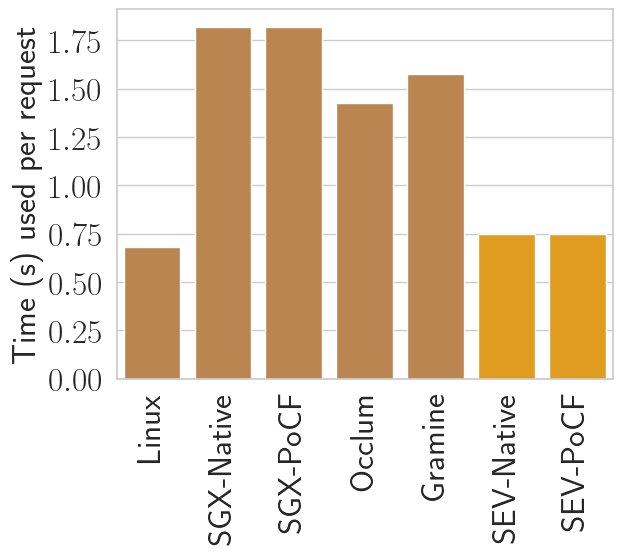

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# If you do not want to plot other platforms, you just need to remove those unneeded.
platforms = ['rust', 'native', 'pobf', 'occlum', 'gramine']

ys = []
for platform in platforms:
    pos = -2
    if platform == 'pobf' or platform == 'native':
          pos = 0
    _, trpt = analyze_macrobenchmarks('output_enclave_' + platform, 'mt', pos=pos)
    for k,v in trpt.items():
        ys.append(v[0] / 1000)

# If you do not want to plot other platforms, you just need to remove those unneeded.
xs =  ['Linux', 'SGX-Native', 'SGX-PoCF',  'Occlum', 'Gramine', 'SEV-Native', 'SEV-PoCF',]

sns.set(style='whitegrid')
ys = ys[1::2]

ys.append(0.7467)
ys.append(0.74895)

colors = ['peru', 'peru', 'peru', 'peru', 'peru',  'orange', 'orange',]

g = sns.barplot(x=xs, y=ys, palette=colors)
g.set_ylabel('Time (s) used per request', fontsize=24)
g.set_xticklabels(g.get_xticklabels(), size=24, rotation=90)
g.set_yticklabels(g.get_yticklabels(), size=24)
plt.savefig("./macrobenchmarks_mt_fasta.pdf", bbox_inches='tight')
